_Pablo Latorre and Hafid Laayouni_

You need to install the following Python packages: pandas, numpy, matplotlib, statsmodels, scipy and pingouin.

You can do it in Linux, for instance, with [pip installer](https://pip.pypa.io/en/stable/installing/) by typing the following command in the terminal:

__sudo pip install pandas numpy matplotlib statsmodels scipy pingouin__

First of all you have to import in Python the following packages:

In [55]:
# loading required functions and modules #
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.graphics.factorplots import interaction_plot
import pingouin as pg

Besides, at the end of this document there is a **Functions' guide** section with practical information about some of the functions used in this session.

# Introduction to Two-way ANOVA

## Definition

In the last practical lesson we studied the relationship between one continuous dependent variable and one
categorical independent variable. However, when we have more than one independent categorical variable we have to use _N-way_ ANOVA. We will see the case when we have two independent categorical variables, so we will use a _two-way_ ANOVA.

## Assumptions

Remember, in order to use the ANOVA test statistic, three main assumptions must be satisfied:

* The dependent variable is normally distributed in each group.

* There is homogeneity of variances, the population variances in each group are equal.

* Independence of observations within and across groups.

# Example

A researcher wanted to study the effects of adult density and season on egg mass production by intertidal limpets. He manipulated the density of adults limpets within enclosures (8, 15, 30 and 45 individuals per enclosure) during two seasons (winter-spring and summer-autumn). Three replicate enclosures per density/season combination were used.

![Figure 1: Limpet](limpet.png "limpet")

First, import the limpet data set (_limpet.csv_). Look at the data: how many factors do we have? How many categories are in each factor? What is the number of replicates?

**HINT**: You can use *pd.read_csv()* function to open a .csv file and *groupby()* function to group your continous variable ('EGGS') respect to the categorical variables ('DENSITY' and 'SEASON').

In [56]:
df=pd.read_csv('limpet.csv')
df.head()

,DENSITY,SEASON,EGGS
0,8,spring,2.875
1,8,spring,2.625
2,8,spring,1.750
3,8,summer,2.125
4,8,summer,1.500


In [57]:
df.groupby(['DENSITY','SEASON']).agg('mean')


EGGS
DENSITY SEASON          
8       spring  2.416667
        summer  1.833333
15      spring  2.177333
        summer  1.177667
30      spring  1.565333
        summer  0.811333
45      spring  1.199667
        summer  0.592667

In this experiment both density and season were considered fixed factors, and thus the data represent a Model I design. Take a look at the dispersion of the variable of interest (number of Eggs) depending on each factor separately and together. For that, we can take a look to boxplots.

{'whiskers': [<matplotlib.lines.Line2D at 0x25c4b089888>,
 'caps': [<matplotlib.lines.Line2D at 0x25c4b1caf48>,
 'boxes': [<matplotlib.lines.Line2D at 0x25c4b1ca208>],
 'medians': [<matplotlib.lines.Line2D at 0x25c4b1d1ec8>],
 'fliers': [<matplotlib.lines.Line2D at 0x25c4b1d1fc8>],
 'means': []}

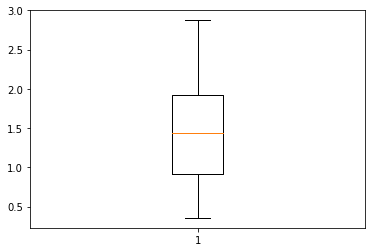

In [15]:
plt.boxplot(df.EGGS)

In [58]:
#We have to treat density and season as a category:
df['SEASON'].unique()
df['DENSITY'].unique()

array([ 8, 15, 30, 45], dtype=int64)

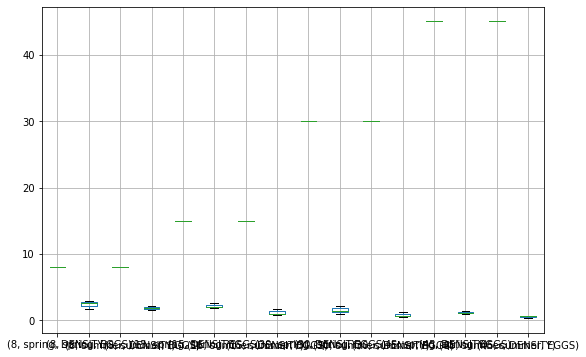

In [60]:
df.groupby(['DENSITY','SEASON']).boxplot(df.EGGS, figsize = (9,6))

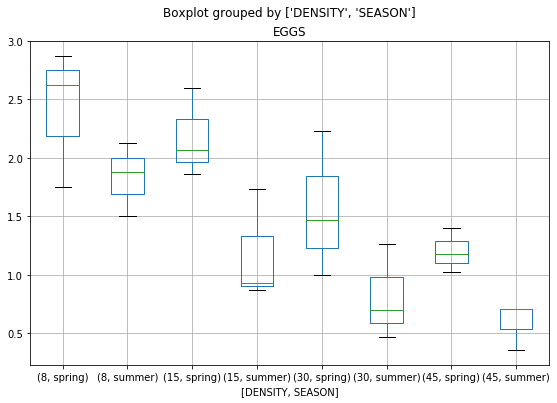

In [61]:
df.boxplot(column = 'EGGS', by = ['DENSITY','SEASON'], figsize = (9,6))
plt.show()

No evidence of non-normality (boxplots are not wildly asymmetrical).

To ckeck normality in a formal way use the statistical test Kolmogorov-Smirnov.

In [17]:
mean = np.mean(df['EGGS'])
sd = np.std(df['EGGS'], ddof = 1)
stats.kstest(df['EGGS'], 'norm', args = (mean, sd))

KstestResult(statistic=0.11160795826594538, pvalue=0.926028526039178)

P-value is high, so we accept the null hypothesis: data follows a normal distribution.

To perform the two-way ANOVA we have to write the variable of interest as a function of the two factors and their interaction. 

**HINT**: You can take into account both factors together plus their interaction with the following expression: EGGS ~ C(DENSITY) + C(SEASON) + C(DENSITY) : C(SEASON), where C() indicates that a variable is categorical. Wouldn't be needed in season because it's a string. If not density would be considered an integer.

We could also use 'EGGS ~ C(DENSITY)*C(SEASON)

In [51]:
mod=ols('EGGS ~ C(DENSITY) + C(SEASON) + C(DENSITY):C(SEASON)',data=df).fit()
sm.stats.anova_lm(mod)

,df,sum_sq,mean_sq,F,PR(>F)
C(DENSITY),3.0,5.284139,1.761380,9.669120,0.000704
C(SEASON),1.0,3.250176,3.250176,17.841890,0.000645
C(DENSITY):C(SEASON),3.0,0.164688,0.054896,0.301353,0.823955
Residual,16.0,2.914647,0.182165,NaN,NaN


Looks like both season and density affect eggs but that there's not really an interaction between them. 

Effect size: That's what we should calculate in order to get importance. From the table, we could argue that season plays a more important role than density because F is larger, but apparently we shouldn't report it that way. p value is about statistical significance, not practical significance: ability to change something. 

The conclusion is that both the density and the season affect the number of eggs, but there is no interaction
between the two factors. As we have seen that the means of each category of density and season are different,
we will apply a *pairwise t-test* on each factor.

In [62]:
pg.pairwise_ttests(df, dv = 'EGGS', between = 'SEASON', padjust = 'bonf') #it doesn't do a correction because there's only one pair.

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,SEASON,spring,summer,False,True,2.92396,22.0,two-sided,0.00786,6.159,1.15254


Spring and summer don't get the same results

In [21]:
pg.pairwise_ttests(df, dv = 'EGGS', between = 'DENSITY', padjust = 'bonf')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,DENSITY,8,15,False,True,1.281540,10.0,two-sided,0.228921,1.000000,bonf,0.771,0.682983
1,DENSITY,8,30,False,True,2.795141,10.0,two-sided,0.018952,0.113711,bonf,3.386,1.489639
2,DENSITY,8,45,False,True,4.627887,10.0,two-sided,0.000939,0.005635,bonf,29.585,2.466380
3,DENSITY,15,30,False,True,1.305124,10.0,two-sided,0.221082,1.000000,bonf,0.785,0.695551
4,DENSITY,15,45,False,True,2.487161,10.0,two-sided,0.032146,0.192877,bonf,2.4,1.325504
5,DENSITY,30,45,False,True,0.979066,10.0,two-sided,0.350639,1.000000,bonf,0.631,0.521782


Only significant diffeerences betweeen 8-45

We only find differences between the mean of the highest (45) and lowest (8) density, and the difference on number of eggs in summer and spring is significant. To look at the combined effect of both factors, we draw the interaction plot.

**HINT**: For drawing an interaction plot, you can use *interaction_plot()* function

C:\Users\marta\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


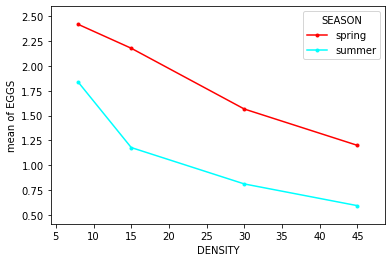

In [34]:
fig=interaction_plot(x=df.DENSITY, trace=df.SEASON, response=df.EGGS)
fig.show()

If we need to calculate, for instance the mean, for each of the combinations of season and density (8 combinations) we may use again the *groupby()* function from Pandas.


# Exercise 1. To be submited
In a similar experiment to that shown in the example, the same researcher also manipulated the density of larger adults limpets further down the shoreline within enclosures (6, 12 and 24 individuals per enclosure)
during the two seasons (winter-spring and summer-autumn) so as to investigate their effects on egg mass
production. Again, three replicate enclosures per density/season combination were used, and both density
and season were considered fixed factors. Data is available in a separate document ("Table_Exercise1.png").
Look at the data: how many factors do we have? How many categories are in each factor? What is the
number of replicates?


From the table construct the dataset in order to be able to analyse it in Python (remember to create it in long
format). Either write the data directly in the script or create a file and read it into Python. If you create a file
remember to upload it to the Campus too.


In this experiment both density and season were considered fixed factors, and thus the data represent a
Model I design. Look at the dispersion of the variable of interest (number of Eggs) depending on each factor
separately and together. Perform the two-way ANOVA and do the interaction plot. What can you say about the plot? In which season do they lay more eggs? How affects the density to the number of eggs? Do the factors interact?

In this case we have two independent variables : Density and season, which are the factors. Density has three categories (6,12,24) and Season has two : spring and summer. The number of replicates, also known as the number of measurements under the same conditions is three.


In [4]:
density = np.repeat([6,12,24],6)
season = np.repeat(['Spring','Summer']*3,3)
egg = np.array(
    [1.167,0.5,1.667,4,3.83,3.83,
     1.5,0.833,1,3.33,2.58,2.75,
     0.667,0.667,0.75,2.54,1.83,1.63],
    dtype=float
              )

data_ex1 = pd.DataFrame(
    list(zip(density, season,egg)), 
    columns =['Density', 'Season', 'Egg']
)

data_ex1.head()

,Density,Season,Egg
0,6,Spring,1.167
1,6,Spring,0.500
2,6,Spring,1.667
3,6,Summer,4.000
4,6,Summer,3.830


Text(0.5, 1.0, 'Distribution of eggs within the two factors')

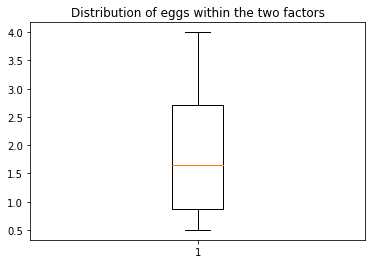

In [11]:
plt.boxplot(data_ex1.Egg)
plt.title('Distribution of eggs within the two factors')

In [25]:
mean=np.mean(data_ex1['Egg'])
std=np.std(data_ex1['Egg'], ddof=1)
print(mean,std)

1.9483888888888887 1.2019102021311443


In [26]:
stats.kstest(data_ex1.Egg, 'norm', args=(mean, std))

KstestResult(statistic=0.15034371757673393, pvalue=0.8105590496858872)

P value is almost one: the distribution is nearly normal!


In [48]:
mod=ols('Egg ~ C(Density) + C(Season) + C(Density):C(Season)',data=data_ex1).fit()
sm.stats.anova_lm(mod)

,df,sum_sq,mean_sq,F,PR(>F)
C(Density),2.0,4.001910,2.000955,13.984179,7.324696e-04
C(Season),1.0,17.148320,17.148320,119.845363,1.335587e-07
C(Density):C(Season),2.0,1.690723,0.845362,5.908024,1.636324e-02
Residual,12.0,1.717045,0.143087,NaN,NaN


In [29]:
pg.pairwise_ttests(data_ex1, dv = 'Egg', between = 'Season', padjust = 'bonf')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Season,Spring,Summer,False,True,-6.085147,16.0,two-sided,0.000016,930.203,-2.731968


In [30]:
pg.pairwise_ttests(data_ex1, dv = 'Egg', between = 'Density', padjust = 'bonf')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,Density,6,12,False,True,0.654157,10.0,two-sided,0.527767,1.000000,bonf,0.536,0.348626
1,Density,6,24,False,True,1.613901,10.0,two-sided,0.137624,0.412871,bonf,1.007,0.860110
2,Density,12,24,False,True,1.238799,10.0,two-sided,0.243709,0.731128,bonf,0.748,0.660204


C:\Users\marta\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


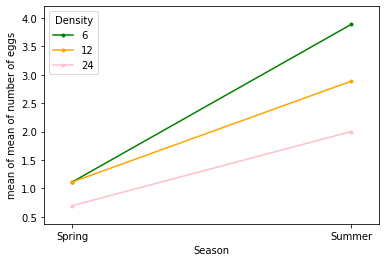

In [54]:
fig=interaction_plot(x=data_ex1.Season, trace=data_ex1.Density, response=data_ex1.Egg, ylabel='mean of number of eggs', colors=['green', 'orange', 'pink'])
fig.show()

C:\Users\marta\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


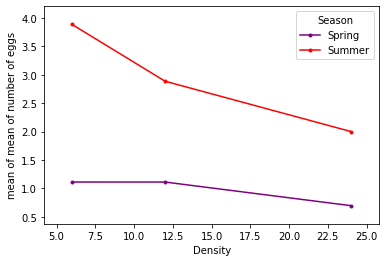

In [64]:
fig=interaction_plot(x=data_ex1.Density, trace=data_ex1.Season, response=data_ex1.Egg, ylabel='mean of number of eggs', colors=['purple', 'red'])
fig.show()

In [35]:
interaction_plot?

# Functions' guide


Here you can find a brief help section for the most relevant functions and arguments used through the session. For detailled information about specific functions and extra functionalities remember that you can check the manual of a function by typing *help(your_function)* or just using Google. 
  

* **stats.kstest(data, 'norm', args = (mean, sd))**

    Performs the one sample Kolmogorov-Smirnov test for goodness of fit.
    
    We specify we want to test our data against a normal distribution with 'norm' argument. In addition, we specify we want that normal distribution to have a given mean and standard deviation with args = ().
    
  
* **ols('variable1 ~ variable2 + variable3 + variable2:variable3',data=data).fit()**

    Create a model from a formula and dataframe

    *variable1 ~ variable2 + variable3 + variable2:variable3* is the notation expected from the function in this case. It specifies that variable1 is the dependent variable and variable2 and 3 are the independent variables. In addition, with variable2:variable3 we specify that we want to test the interaction of variable2 and variable3. These variables should be present as columns of your data (long format data).
    
    *ols()* function creates the model and *fit()* is for fitting it.     
    

* **sm.stats.anova_lm(mod)**

    Anova table for one or more fitted linear models.
    
    mod is the fitted model created with the *ols().fit()* functions.
    

* **pg.pairwise_ttests(data, dv = continous_variable_name,** 
    **between = categorical_variable_name, padjust = 'bonf')**

    Pairwise T-tests.

    Tests for multiple comparisons. In this case, we are using pairwise t-test.
    
    dv specifes the continuos variable,
    
    between refers to to categorial variable.
    
    padjust indicates the type of multiple testing correction we want to use. In this case we want bonferroni. Other options are, for example, 'holm' or 'fdr_bh.'
    
    
* **interaction_plot(x = categorical_variable1, trace = categorial_varible2, response = continous_variable)**

    Interaction plot for factor level statistics.

    categorical_variable1 = Categorical variable that will be displayed in the x-axis.
    
    categorical_variable2 = Categorical variable that will be considered as different lines in the interaction plot.
    
    continous_variable = Dependent variable that will be displayed in the y-axis.
    




Bonforroni is not really good for small datasets